# MPS Evolution with TEBD

This example demonstrates use of the {class}`~quimb.tensor.tensor_tebd.TEBD` object to simulate the time evolution of matrix product states.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np

import quimb as qu
import quimb.tensor as qtn

To address an interesting and practical case (entanglement doesn't grow too much) we'll use as
an initial state the all zero state apart from two flipped spins:

In [2]:
L = 44
zeros = "0" * ((L - 2) // 3)
binary = zeros + "1" + zeros + "1" + zeros
print("psi0:", f"|{binary}>")

psi0: |00000000000000100000000000000100000000000000>


We can turn this into a {class}`~quimb.tensor.tn1d.core.MatrixProductState` using
{func}`~quimb.tensor.tensor_builder.MPS_computational_state`:

In [3]:
psi0 = qtn.MPS_computational_state(binary)
psi0.show()  # prints ascii representation of state

     1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1    
... >─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─ ...
    │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │     
                                 ...                                  
     1 1 1 1 1 1 1 1 
    >─>─>─>─>─>─>─>─●
    │ │ │ │ │ │ │ │ │


To set the hamiltonian, we need to define a nearest neighbour interaction
({class}`~quimb.tensor.tensor_tebd.LocalHam1D`) hamiltonian. These can built directly
using arrays representing the one and two site terms, or from
a {class}`~quimb.tensor.tensor_builder.SpinHam1D`.
But, for the Heisenberg hamiltonian with no magnetic field,

$$
\hat{H} = J \sum_{i=1}^{L - 1} \mathbf{\sigma}_i \cdot \mathbf{\sigma}_{i + 1} ~ ,
$$

we'll use a built-in:

In [4]:
H = qtn.ham_1d_heis(L)

Now we are ready to set-up the actual {class}`~quimb.tensor.tensor_tebd.TEBD` object,
which trys to mimic the api of the normal {class}`~quimb.evo.Evolution` object.

We could set a default timestep `dt` here, or instead, a default tolerance `tol`,
which calculates `dt` automatically based on the total evolution length, trotter
decomposition order, and hamiltonian norm.

In [5]:
tebd = qtn.TEBD(psi0, H)

# Since entanglement will not grow too much, we can set quite
#     a small cutoff for splitting after each gate application
tebd.split_opts["cutoff"] = 1e-12

We'll also set up some parameters and quantities to compute during the evolution:

In [6]:
# times we are interested in
ts = np.linspace(0, 80, 101)

mz_t_j = []  # z-magnetization
be_t_b = []  # block entropy
sg_t_b = []  # schmidt gap

# range of bonds, and sites
js = np.arange(0, L)
bs = np.arange(1, L)

Now we are ready to being the evolution, we use the generator
``at_times`` to yield the state at each target time, and set
a ``tol`` here which will calculate a timestep to use.
At each time, we'll compute the desired quantities and add them
to our results.

In [7]:
# generate the state at each time in ts
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(ts, tol=1e-3):
    mz_j = []
    be_b = []
    sg_b = []

    # there is one more site than bond, so start with mag
    #     this also sets the orthog center to 0, which ``info`` then tracks
    info = {"cur_orthog": None}
    mz_j += [psit.magnetization(0, info=info)]

    for j in range(1, L):
        mz_j += [psit.magnetization(j, info=info)]
        be_b += [psit.entropy(j, info=info)]
        sg_b += [psit.schmidt_gap(j, info=info)]

    mz_t_j += [mz_j]
    be_t_b += [be_b]
    sg_t_b += [sg_b]

t=80, max-bond=15: 100%|##########| 101/101 [02:05<00:00,  1.25s/it]  


In [8]:
tebd.pt.show()

     2 4 5 6 7 8 9 10 11 12 13 14 14 14 15 14 14 15 14 14 14 15 15 15 14 1    
... >─>─>─>─>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>─ ...
    │ │ │ │ │ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │     
                                 ...                                  
    5 14 14 14 15 14 14 13 12 11 10 9 8 7 6 5 4 2 
    ─>──>──>──>──>──>──>──>──>──>──>─>─>─>─>─>─>─●
     │  │  │  │  │  │  │  │  │  │  │ │ │ │ │ │ │ │


``TEBD.err`` contains a (rough) upper estimate for the error
incurred by the trotter decomposition so far:

In [9]:
tebd.err  #  should be < tol=1e-3

0.0009938931328611381

We can also check the normalization of final state:

In [10]:
tebd.pt.H @ tebd.pt

0.9999999878089972

And that energy has been conserved:

In [11]:
H = qtn.MPO_ham_heis(L)
print("Initial energy:", qtn.expec_TN_1D(psi0.H, H, psi0))
print("Final energy:", qtn.expec_TN_1D(tebd.pt.H, H, tebd.pt))

Initial energy: 8.75
Final energy: 8.749999702600311


Finally let's plot the quantities we calculated:

In [12]:
import matplotlib.pyplot as plt

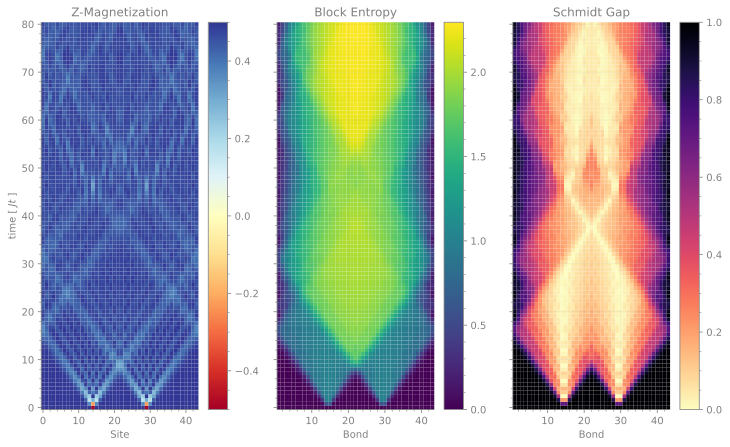

In [13]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plt.figure(figsize=(12, 7))

    # plot the magnetization
    ax1 = plt.subplot(131)
    plt.pcolormesh(js, ts, np.real(mz_t_j), vmin=-0.5, vmax=0.5)
    plt.set_cmap("RdYlBu")
    plt.colorbar()
    plt.title("Z-Magnetization")
    plt.xlabel("Site")
    plt.ylabel("time [ $Jt$ ]")

    # plot the entropy
    ax2 = plt.subplot(132, sharey=ax1)
    plt.pcolormesh(bs, ts, be_t_b)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.set_cmap("viridis"), plt.colorbar()
    plt.title("Block Entropy")
    plt.xlabel("Bond")

    # plot the schmidt gap
    ax3 = plt.subplot(133, sharey=ax1)
    plt.pcolormesh(bs, ts, sg_t_b, vmin=0, vmax=1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.set_cmap("magma_r")
    plt.colorbar()
    plt.title("Schmidt Gap")
    plt.xlabel("Bond")

    plt.show()

Where we can see ballistic propagation (and reflection) of the 'light cone'.

## Non-translationally invariant Hamiltonians

The ``LocalHam1D`` class can also handle Hamiltonians with site specific interactions and fields.
A good example of this is the Many-Body-Localized spin hamiltonian:

$$
    \hat{H} = J \sum_{i=1}^{L - 1} \mathbf{\sigma}_i \cdot \mathbf{\sigma}_{i + 1}
    + \sum_i^L h_i \sigma^Z_i
$$

Where $h_i$ is a random variable. Here we construct it manually:

In [14]:
builder = qtn.SpinHam1D(S=1 / 2)

# specify the interaction term (defaults to all sites)
builder += 0.5, "+", "-"
builder += 0.5, "-", "+"
builder += 1.0, "Z", "Z"

# add random z-fields to each site
np.random.seed(2)
for i in range(L):
    builder[i] += 2 * np.random.rand() - 1, "Z"

H = builder.build_local_ham(L)

But there is also the built-in {func}`~quimb.tensor.tensor_builder.ham1d_mbl`
which has options for various random noise types etc.

We can perform the same TEBD evolution as above with this new Hamiltonian:

In [15]:
tebd = qtn.TEBD(psi0, H)
tebd.split_opts["cutoff"] = 1e-10

# times we are interested in
ts = np.linspace(0, 80, 101)

mz_t_j = []  # z-magnetization
be_t_b = []  # block entropy
sg_t_b = []  # schmidt gap

# range of bonds, and sites
js = np.arange(0, L)
bs = np.arange(1, L)

In [16]:
# generate the state at each time in ts
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(ts, tol=1e-3):
    mz_j = []
    be_b = []
    sg_b = []

    # there is one more site than bond, so start with mag
    #     this also sets the orthog center to 0, which ``info`` then tracks
    info = {"cur_orthog": None}
    mz_j += [psit.magnetization(0, info=info)]

    for j in range(1, L):
        mz_j += [psit.magnetization(j, info=info)]
        be_b += [psit.entropy(j, info=info)]
        sg_b += [psit.schmidt_gap(j, info=info)]

    mz_t_j += [mz_j]
    be_t_b += [be_b]
    sg_t_b += [sg_b]

t=80, max-bond=19: 100%|##########| 101/101 [02:45<00:00,  1.64s/it]  


And finally, plot the quantities again:

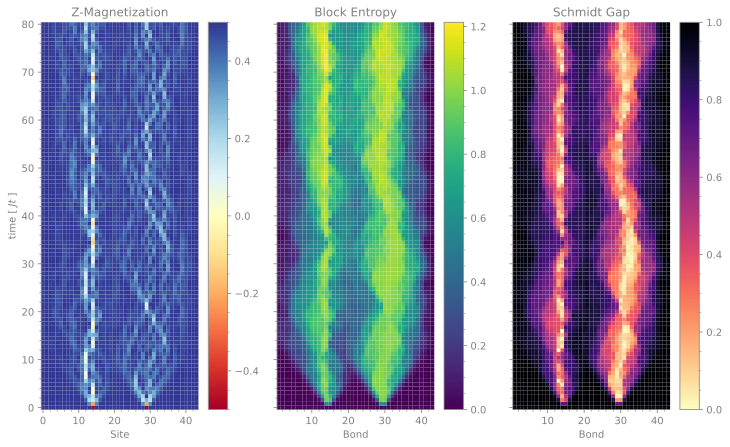

In [17]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plt.figure(figsize=(12, 7))

    # plot the magnetization
    ax1 = plt.subplot(131)
    plt.pcolormesh(js, ts, np.real(mz_t_j), vmin=-0.5, vmax=0.5)
    plt.set_cmap("RdYlBu")
    plt.colorbar()
    plt.title("Z-Magnetization")
    plt.xlabel("Site")
    plt.ylabel("time [ $Jt$ ]")

    # plot the entropy
    ax2 = plt.subplot(132, sharey=ax1)
    plt.pcolormesh(bs, ts, be_t_b)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.set_cmap("viridis"), plt.colorbar()
    plt.title("Block Entropy")
    plt.xlabel("Bond")

    # plot the schmidt gap
    ax3 = plt.subplot(133, sharey=ax1)
    plt.pcolormesh(bs, ts, sg_t_b, vmin=0, vmax=1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.set_cmap("magma_r")
    plt.colorbar()
    plt.title("Schmidt Gap")
    plt.xlabel("Bond")

    plt.show()

Here we can see much more confinement.